# Image Filtering

In [1]:
# Code from previous section
using Plots
using FileIO

function fastdisplay(h=current())
    fname = savefig(h, tempname())
    display("image/png", read(fname))
    rm(fname, force=true)
end

to3Darray(img) = Float32[ getfield(pxl, fld) for pxl in img, fld in (:r,:g,:b) ]
toRGBarray(img) = RGB.(eachslice(img[:,:,:], dims=3)...)
imread(filename) = to3Darray(load(filename))
imshow(img; args...) = plot(toRGBarray(img); aspect_ratio=:equal, axis=nothing, border=:none, args...)
image_threshold(A, th) = Float64.(A .> th)

image_threshold (generic function with 1 method)

In [2]:
# Read sample image and convert to grayscale
A = imread("sample_photo.png")
B = sum(A, dims=3) / 3;

In **spatial filtering**, we compute the value of a new pixel based on the values in a small neighborhood of the corresponding pixel in the original image. This neighborhood is often called a **mask** or **kernel**.

A simple example is an **average filter**. For each pixel, we take its 3x3 neighborhood (the pixel itself and its 8 immediate neighbors) and calculate the average value. The pixel in our new image is set to this average. This is a "sliding window" operation.

In [3]:
using Statistics  # for mean and median functions

function image_avgfilter(A)
    # Pre-allocate an output array `B` with the same size and type as `A`,
    # but initialized to all zeros.
    B = 0*A
    
    # Loop over all *interior* pixels. 
    # We start at 2 and end at size-1 to avoid running the 3x3 mask
    # off the edge of the image (which would cause a BoundsError).
    # The 1-pixel border of `B` will remain 0.
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        # Extract the 3x3 neighborhood (a 3x3 sub-array)
        patch = A[i-1:i+1, j-1:j+1]
        # Calculate the mean of all 9 pixels in the patch
        B[i,j] = mean(patch)
    end
    return B
end

image_avgfilter (generic function with 1 method)

## Smoothing and Blurring

If we apply this average filter repeatedly, the image gets progressively softer. This is because each pixel's value is being spread out to its neighbors. This operation is known as **smoothing** or **blurring**. It removes sharp details and high-frequency patterns.

Let's create a helper function to visualize this cumulative effect on a zoomed-in portion of the image.

In [4]:
# A helper function to demonstrate a filter's effect over multiple applications.
function filter_demo(B, filter_function)
    # We must copy B! Otherwise, `E = B` would modify the original `B`
    # on every function call, which we don't want.
    E = copy(B);
    plts = []
    
    for i = 1:4
        # Show a cropped region: [y_start:y_end, x_start:x_end, all_channels]
        push!(plts, imshow(E[260:350,300:420,:], title="$(i-1) filter passes"))
        
        # Apply the filter to the *entire* image for the next iteration
        E = filter_function(E)
    end
    fastdisplay(plot(plts..., layout=(2,2)))
end

filter_demo (generic function with 1 method)

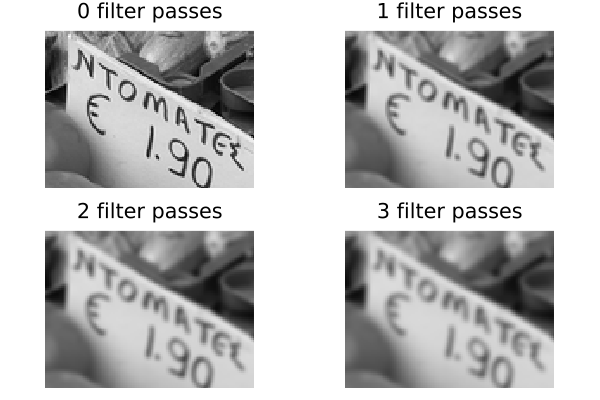

In [5]:
# Run the demo with our average filter
filter_demo(B, image_avgfilter)

## Denoising with an Average Filter

This smoothing property is very useful for noise reduction. If our image is corrupted with **Gaussian noise** (where each pixel's value is randomly shifted up or down a little), the averaging filter will "average out" these random variations, resulting in a cleaner image.

Let's add some normally distributed random noise and see what happens.

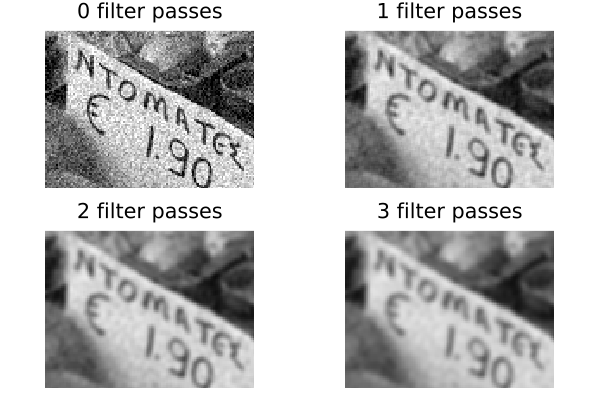

In [6]:
# `randn(size(B))` creates an array of random numbers (mean=0, stddev=1)
# We scale it by 0.1 to make the noise subtle.
Bnoise = B + 0.1randn(size(B))

# Important: Adding noise can push values outside the [0.0, 1.0] range.
# We must `clamp` them back (or use max/min) to get a valid image.
Bnoise = max.(min.(Bnoise, 1.0), 0.0)

# Run the filter demo on the noisy image
filter_demo(Bnoise, image_avgfilter)

## Median Filtering: A Robust Alternative

A slight variation is the **median filter**. Instead of taking the *mean* of the 9 pixels in the 3x3 mask, it takes the *median* (the middle value after sorting them).

This filter is a **non-linear** filter (the median is not a linear operation) and has a very different effect. It's excellent at preserving sharp edges while still removing noise.

In [7]:
function image_medianfilter(A)
    B = 0*A
    # The loop structure is identical to the average filter
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        # But here, we compute the median of the 3x3 patch
        B[i,j] = median(A[i-1:i+1, j-1:j+1])
    end
    return B
end

image_medianfilter (generic function with 1 method)

The median filter is particularly good at removing **impulse noise**, often called **"salt and pepper" noise**. This is where a few pixels are randomly set to pure black (0.0) or pure white (1.0), which can be caused by sensor defects or transmission errors. 

An average filter would be heavily skewed by a single 0.0 or 1.0 value. A median filter, however, will just treat that extreme value as an outlier, and the resulting pixel will be one of the other 8 "normal" values in the patch.

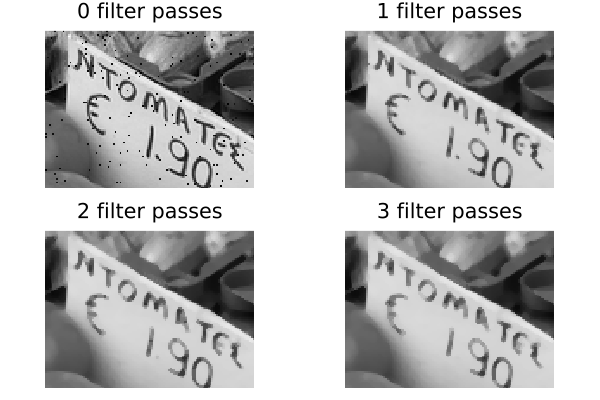

In [8]:
Bnoise2 = copy(B)

# To simulate "pepper" noise:
# 1. `rand(1:length(B), 10000)`: Select 10,000 random pixel indices
# 2. `... = 0.1rand(10000)`: Set those pixels to random *dark* values
Bnoise2[rand(1:length(B), 10000)] = 0.1rand(10000)

# Run the demo. Notice how effectively the median filter 
# removes the black dots, while the average filter would just blur them.
filter_demo(Bnoise2, image_medianfilter)

## Edge Detection: Finding Sharp Changes

The previous filters (smoothing/blurring) are called *low-pass* filters because they preserve the low-frequency, smooth parts of an image. Now we'll do the opposite: create a *high-pass* filter to find sharp variations, or **edges**.

We can detect changes by approximating the **gradient** of the image intensity. The gradient measures how fast the intensity is changing in the vertical (y) and horizontal (x) directions.

We will use a *centered difference* approximation for the gradient at pixel `(i, j)`:

$$
\nabla A_{ij} \approx
\begin{pmatrix}
(\text{Vertical change}) \\
(\text{Horizontal change})
\end{pmatrix}
\approx
\begin{pmatrix}
A_{i+1,j} - A_{i-1,j} \\
A_{i,j+1} - A_{i,j-1} \\
\end{pmatrix}
$$

A large positive or negative value in either component means a sharp change. Our filter will compute the maximum of the *absolute values* of these two components.

In [9]:
function image_maxabsgradfilter(A)
    B = 0*A
    for i = 2:size(A,1)-1, j = 2:size(A,2)-1
        # Extract the 3x3 patch
        a = A[i-1:i+1, j-1:j+1]
        
        # Calculate vertical gradient: (pixel below) - (pixel above)
        grad_y = a[3,2] - a[1,2]
        
        # Calculate horizontal gradient: (pixel right) - (pixel left)
        grad_x = a[2,3] - a[2,1]
        
        # The new pixel value is the *strongest* gradient in either direction.
        B[i,j] = max(abs(grad_y), abs(grad_x))
    end
    return B
end

image_maxabsgradfilter (generic function with 1 method)

To improve edge detection, it's common to **first smooth the image slightly**. This removes minor noise, ensuring that our gradient filter only detects significant, structural edges and not random, noisy pixels.

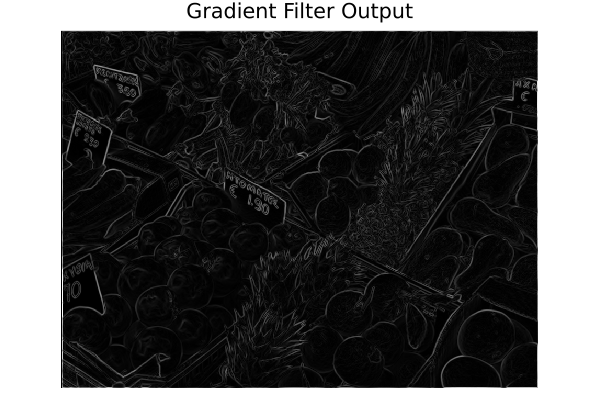

In [10]:
# Step 1: Apply a single pass of the average filter to reduce noise.
Bsmooth = image_avgfilter(B)

# Step 2: Apply the gradient filter to the smoothed image.
Bgrad = image_maxabsgradfilter(Bsmooth)

# The resulting image `Bgrad` is bright where there are edges 
# (high gradient) and dark where the image is smooth (low gradient).
imshow(Bgrad, title="Gradient Filter Output")
fastdisplay()

Finally, we can convert this gradient map into a clean binary image by **thresholding**. We'll select a threshold (e.g., 0.1) and set all pixels *above* it to 1 (white) and all pixels *below* it to 0 (black). 

We then **invert** the image ($1.0 - x$) so the edges become black on a white background, which is a common way to display them.

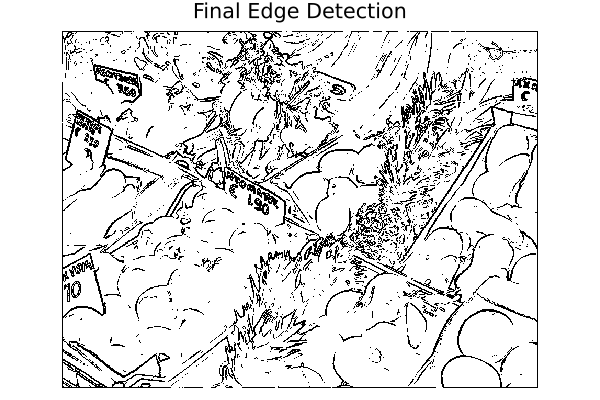

In [11]:
# 1. `image_threshold(Bgrad, 0.1)`: Keep only strong edges (value > 0.1).
#    This creates a binary image (1s for edges, 0s for non-edges).
# 2. `1.0 .- ...`: Invert the image. Edges become 0.0 (black) 
#    and non-edges become 1.0 (white).
Bedges = 1.0 .- image_threshold(Bgrad, 0.1)

imshow(Bedges, title="Final Edge Detection")
fastdisplay()